# Download the Repo and the Data

In [1]:
!git clone https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

Cloning into 'CarND-Traffic-Sign-Classifier-Project'...
remote: Enumerating objects: 343, done.
remote: Total 343 (delta 0), reused 0 (delta 0), pack-reused 343
Receiving objects: 100% (343/343), 1009.70 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [2]:
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

--2018-12-17 18:00:22--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.5
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  21.3MB/s    in 6.4s    

2018-12-17 18:00:29 (18.3 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]



In [3]:
!unzip traffic-signs-data -d traffic-signs-data

Archive:  traffic-signs-data.zip
  inflating: traffic-signs-data/test.p  
  inflating: traffic-signs-data/train.p  
  inflating: traffic-signs-data/valid.p  


# Import the Libraries

In [4]:
!pip install wget

  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import cv2

In [0]:
import tensorflow as tf

In [0]:
from skimage import color
from scipy.misc import imrotate, imresize
from sklearn.utils import shuffle

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score

In [0]:
import collections

In [0]:
import wget

In [0]:
import os
import glob

In [0]:
from IPython.display import HTML

In [195]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Drive

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def upload_file(file_name):
  uploaded = drive.CreateFile({'title': file_name})
  uploaded.SetContentFile(file_name)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

# Data Loading and visualization

## utils

In [0]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
          

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [0]:
def adjust_gamma(image, gamma=1.0):
   invGamma = 1.0 / gamma
   table = np.array([
      ((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)])
   return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

## Load the data

In [0]:
BASE_PATH = 'traffic-signs-data/'

training_file = BASE_PATH + 'train.p'
validation_file=BASE_PATH + 'valid.p'
testing_file = BASE_PATH + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [14]:
print('Shape of training features is {}'.format(X_train.shape))
print('Shape of training labels is {}'.format(y_train.shape))
print('-------------------')
print('Shape of validation features is {}'.format(X_valid.shape))
print('Shape of validation labels is {}'.format(y_valid.shape))
print('-------------------')
print('Shape of testing features is {}'.format(X_test.shape))
print('Shape of testing labels is {}'.format(y_test.shape))

Shape of training features is (34799, 32, 32, 3)
Shape of training labels is (34799,)
-------------------
Shape of validation features is (4410, 32, 32, 3)
Shape of validation labels is (4410,)
-------------------
Shape of testing features is (12630, 32, 32, 3)
Shape of testing labels is (12630,)


In [0]:
signnames = pd.read_csv('./CarND-Traffic-Sign-Classifier-Project/signnames.csv')

In [0]:
pd.options.display.max_columns = 500

In [17]:
signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


## Visualise the data

In [18]:
print('Range of values in training data is {} - {}'.format(np.min(X_train), np.max(X_train)))

Range of values in training data is 0 - 255


In [19]:
print('Number of classes in the data is {}'.format(np.max(y_train)+1))

Number of classes in the data is 43


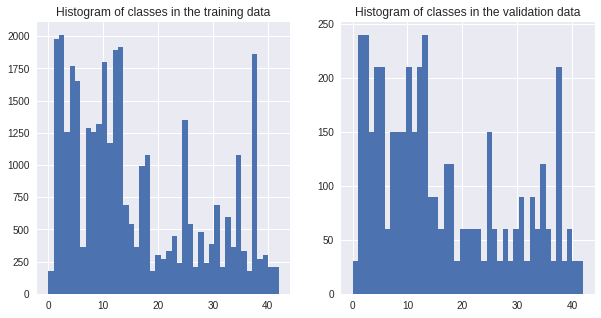

In [20]:
# plt.figure(figsize=(7, 7))
f, axarr = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(10)
axarr[0].hist(y_train, bins=43)
axarr[0].set_title('Histogram of classes in the training data')
# plt.show()
axarr[1].hist(y_valid, bins=43)
axarr[1].set_title('Histogram of classes in the validation data')
plt.show()

**We can notice that the distribution is similar in both training and testing, which is good**

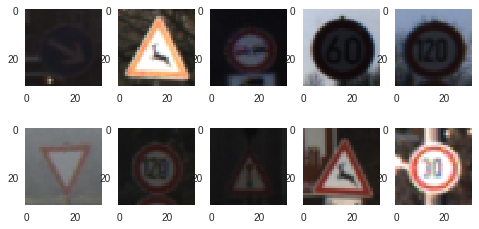

In [26]:
np.random.seed(42)
sample = np.random.choice(X_train.shape[0], 10)
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 2
for i in range(1, columns*rows +1):
  image = X_train[sample[i-1]]
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image)
plt.show()

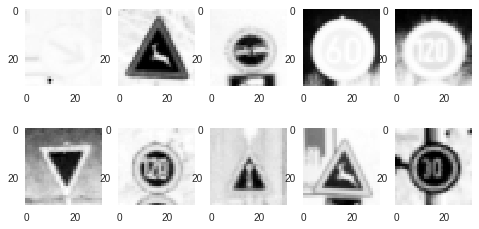

In [35]:
np.random.seed(42)
sample = np.random.choice(X_train.shape[0], 10)
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 2
for i in range(1, columns*rows +1):
  image = cv2.cvtColor(X_train[sample[i-1]], cv2.COLOR_RGB2GRAY)
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image)
plt.show()

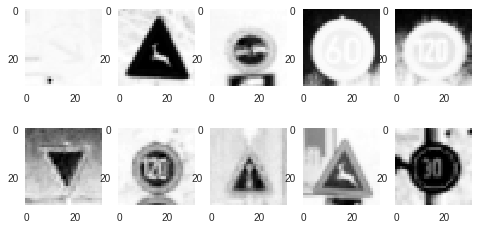

In [32]:
np.random.seed(42)
sample = np.random.choice(X_train.shape[0], 10)
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 2
for i in range(1, columns*rows +1):
  image = cv2.cvtColor(X_train[sample[i-1]], cv2.COLOR_RGB2HSV)
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image[:, :, 2])
plt.show()

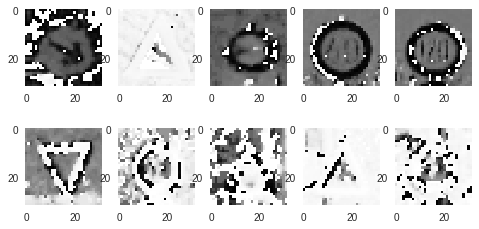

In [34]:
np.random.seed(42)
sample = np.random.choice(X_train.shape[0], 10)
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 2
for i in range(1, columns*rows +1):
  image = cv2.cvtColor(X_train[sample[i-1]], cv2.COLOR_RGB2HSV)
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image[:, :, 0])
plt.show()

**Notes**


*   The illumination is very different from an image to another
*   Some data augmentation may not be good on some classes, such as flipping the "turn right" sign from left to right.



## Prepare the data

In [0]:
def rotate(image):
  angle = np.random.randint(-20, 20)
  img = imrotate(image, angle)
  img = imresize(img, (32, 32))
  return img

def add_noise(image, prob=0.05):
  noise = np.random.normal(size=(32, 32, 1))
  
  zeros = 1-(np.abs(noise) < prob)
  img = (zeros * image)* 1.0

  return img

(32, 32, 3)
float64


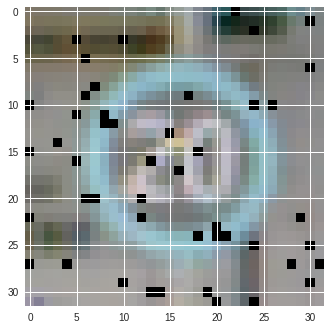

In [37]:
img = X_train[10000]
np.max(img)
img = add_noise(img)
print(img.shape)
print(img.dtype)
plt.imshow(img[:, :, :])

In [0]:
X_train = X_train/255
X_valid = X_valid / 255
X_test = X_test/255

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, 43)
y_valid = tf.keras.utils.to_categorical(y_valid, 43)
y_test = tf.keras.utils.to_categorical(y_test, 43)

In [40]:
X_train_gen = list(map(lambda x: add_noise(rotate(x)), X_train))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [0]:
X_train_all = np.concatenate((X_train_gen, X_train))
y_train_all = np.concatenate((y_train, y_train))

In [0]:
X_train_all, y_train_all = shuffle(X_train_all, y_train_all)

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) 
  
X_train_all = np.array(list(map(lambda x: rgb2gray(x), X_train_all)))

In [44]:
X_train_all.shape

(69598, 32, 32)

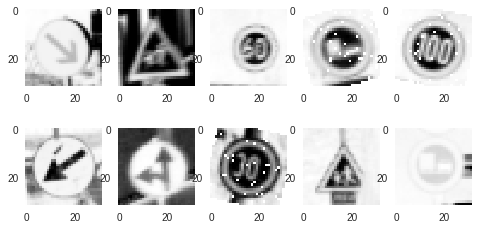

In [45]:
sample = np.random.choice(len(X_train_gen), 10)
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 2
for i in range(1, columns*rows +1):
  image = X_train_all[sample[i-1]]
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image)
plt.show()

In [0]:
X_train_all = X_train_all.reshape(-1, 32, 32, 1)

In [47]:
X_train_all.shape

(69598, 32, 32, 1)

In [0]:
X_valid = np.array(list(map(lambda x: rgb2gray(x), X_valid))).reshape(-1, 32, 32, 1)

In [0]:
X_test = np.array(list(map(lambda x: rgb2gray(x), X_test))).reshape(-1, 32, 32, 1)

# Model

**I am using keras api in tensorflow. The model is a deep CNN model with an inception block at the end. Then, I flatten the CNN result and use 3 fully connected layers. The dropout is used to help prevent overfitting.**

## Training

In [0]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1))
conv = tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(32, 32, 1))(inputs)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(64, 5, strides=2, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(128, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(128, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)

conv1 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME')(conv) 
conv2 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv2) 

conv3 = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='SAME')(conv) 
conv3 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv3) 
          
conv = tf.keras.layers.Concatenate()([conv, conv1, conv2, conv3])
  
conv = tf.keras.layers.Flatten()(conv)
conv = tf.keras.layers.Dense(256, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.5)(conv)
conv = tf.keras.layers.Dense(128, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.5)(conv)
out = tf.keras.layers.Dense(43, activation='softmax')(conv)

model = tf.keras.models.Model(inputs=[inputs], outputs=[out])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/content/weights.hdf5', verbose=1, save_best_only=True)
history=tf.keras.callbacks.History()

op = tf.keras.optimizers.Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=op)

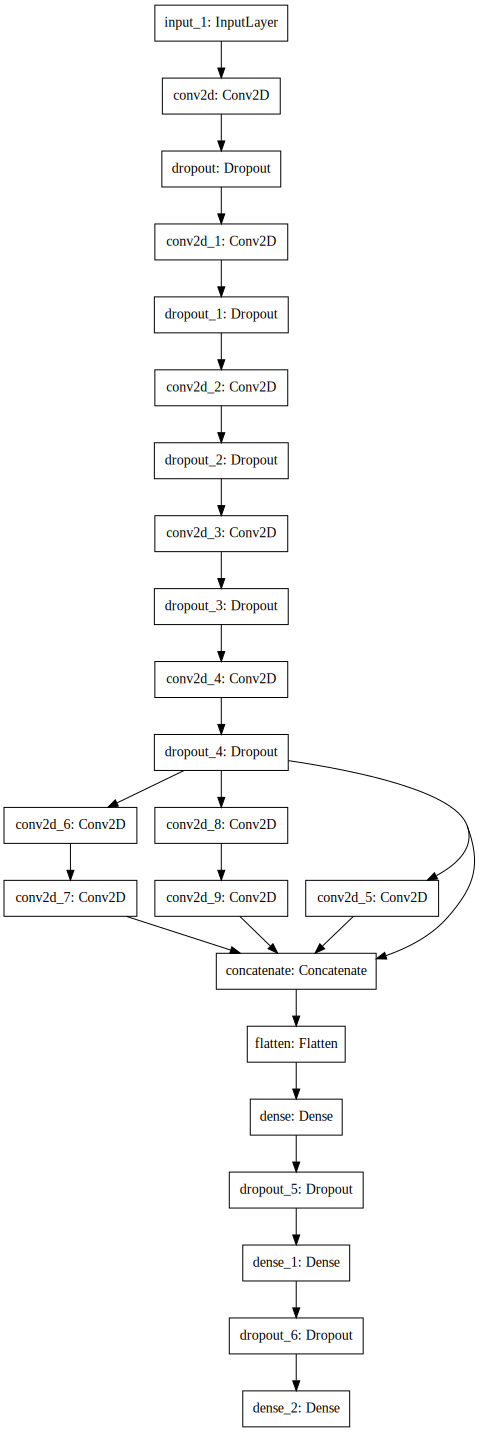

In [196]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [52]:
history=model.fit(X_train_all, y_train_all, epochs=50, batch_size=64,\
                  validation_data=(X_valid, y_valid), callbacks=[reduce_lr, early_stopping, checkpointer])

Train on 69598 samples, validate on 4410 samples
Epoch 1/50
69568/69598 [============================>.] - ETA: 0s - loss: 3.3577 - acc: 0.1167
Epoch 00001: val_loss improved from inf to 1.76080, saving model to /content/weights.hdf5
69598/69598 [==============================] - 65s 939us/step - loss: 3.3572 - acc: 0.1168 - val_loss: 1.7608 - val_acc: 0.5229
Epoch 2/50
69568/69598 [============================>.] - ETA: 0s - loss: 1.2405 - acc: 0.6400
Epoch 00002: val_loss improved from 1.76080 to 0.33971, saving model to /content/weights.hdf5
69598/69598 [==============================] - 60s 860us/step - loss: 1.2406 - acc: 0.6400 - val_loss: 0.3397 - val_acc: 0.8825
Epoch 3/50
69568/69598 [============================>.] - ETA: 0s - loss: 0.5974 - acc: 0.8225
Epoch 00003: val_loss improved from 0.33971 to 0.17646, saving model to /content/weights.hdf5
69598/69598 [==============================] - 60s 861us/step - loss: 0.5973 - acc: 0.8226 - val_loss: 0.1765 - val_acc: 0.9401
Epoc

In [53]:
model2 = tf.keras.models.load_model('./weights.hdf5')
model2.evaluate(X_valid, y_valid)

4410/4410 [==============================] - 2s 356us/step


[0.04379949018613323, 0.9875283446712018]

In [0]:
upload_file('weights.hdf5')

Uploaded file with ID 10TYrQoeRYuuiIQjNrneQVBVvhao8WO7S


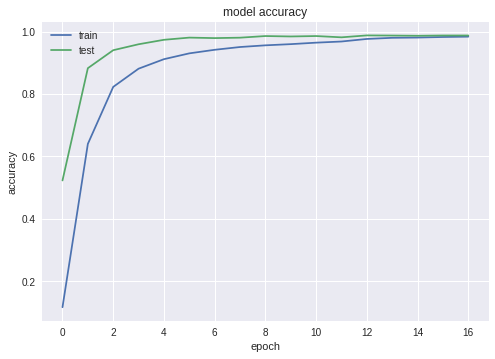

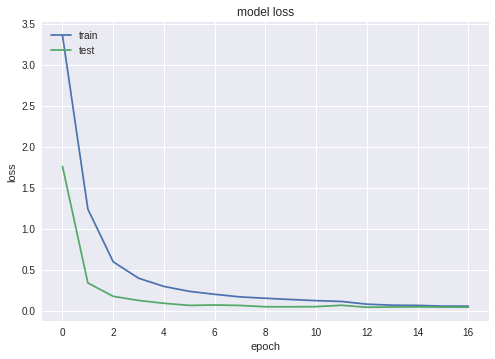

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**We can see that the accuracy and loss of the validation are better than in the training stage because the training data contains the original training data as well as augmented data**

## Explore wrong predictions

In [0]:
def get_wrong_predictions(model_name):
  preds = model_name.predict(X_valid)
  right_preds = np.argmax(preds, 1) == np.argmax(y_valid, 1)
  return np.where(right_preds==False)

In [56]:
ind_wrong = get_wrong_predictions(model2)[0]
print(ind_wrong)

[   0    1    2  271  298  302  303  345  390  391  392  393  394  540
  541  542  543  547  779  800  924 1345 1440 1441 1451 1461 1463 1650
 1790 1863 1865 2070 2157 2660 3240 3241 3242 3244 3245 3246 3247 3248
 3252 3300 3301 3303 3330 3331 3332 3333 3334 3335 3336 3342 3360]


In [0]:
pred_classes = np.argmax(model2.predict(X_valid), 1)
actual_classes = np.argmax(y_valid, 1)

In [58]:
len(ind_wrong)

55

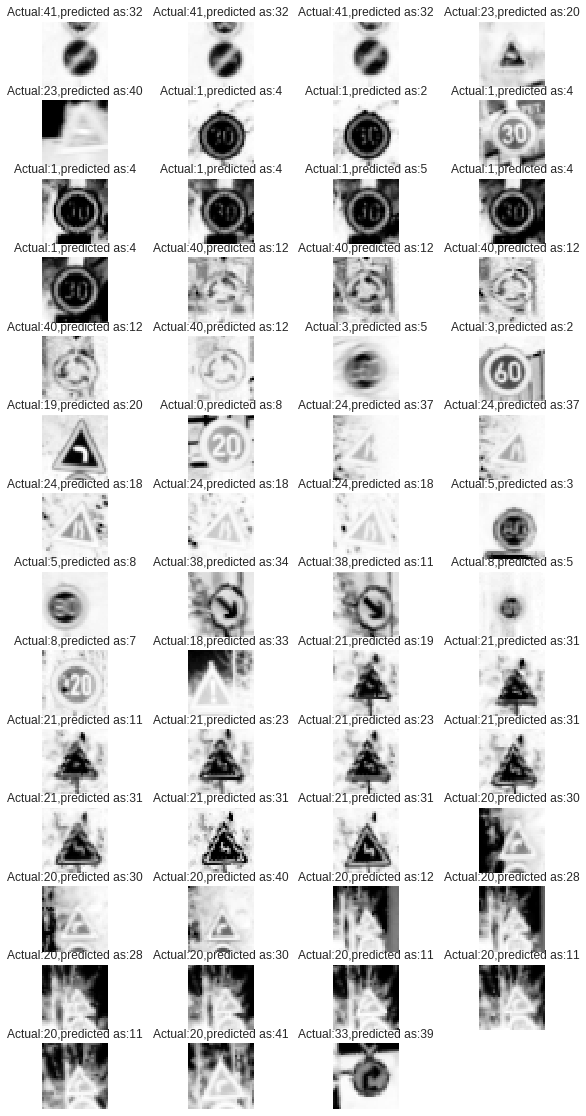

In [82]:
fig=plt.figure(figsize=(10, 20))
w=10
h=10
columns = 4
rows = 14
for i in range(1, 56):
  image = X_valid[ind_wrong[i-1], :, :, 0]
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.title('Actual:{},predicted as:{}'.format(actual_classes[ind_wrong[i-1]], pred_classes[ind_wrong[i-1]]))
#   plt.tight_layout()
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image)

**We can deduce that the model fails to classify similar classes, but tends to predict the class with more data, so we can do oversampling**

## Oversampling

In [0]:
y_train_classes = np.argmax(y_train, 1)

In [0]:
temp = collections.Counter(y_train_classes)

In [0]:
counts = list(map(lambda x: temp[x], range(43)))

In [0]:
min_classes = np.where(np.array(counts) < 750)[0]

In [0]:
y_min_classes = np.array(list(map(lambda x: x in min_classes, y_train_classes)))

In [0]:
X_train_min_classes = X_train[y_min_classes]
y_train_min_classes = y_train[y_min_classes]

In [0]:
X_train_min_classes = np.array(list(map(lambda x: rgb2gray(x), X_train_min_classes))).reshape(-1, 32, 32, 1)

In [0]:
X_train_all2 = np.concatenate((X_train_all, X_train_min_classes))
y_train_all2 = np.concatenate((y_train_all, y_train_min_classes))

In [0]:
X_train_all2, y_train_all2 = shuffle(X_train_all2, y_train_all2)

In [0]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1))
conv = tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(32, 32, 1))(inputs)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(64, 5, strides=2, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(128, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)
conv = tf.keras.layers.Conv2D(128, 3, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.3)(conv)

conv1 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME')(conv) 
conv2 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv2) 

conv3 = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='SAME')(conv) 
conv3 = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='SAME')(conv3) 
          
conv = tf.keras.layers.Concatenate()([conv, conv1, conv2, conv3])
  
conv = tf.keras.layers.Flatten()(conv)
conv = tf.keras.layers.Dense(256, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.5)(conv)
conv = tf.keras.layers.Dense(128, activation='relu')(conv)
conv = tf.keras.layers.Dropout(0.5)(conv)
out = tf.keras.layers.Dense(43, activation='softmax')(conv)

model11 = tf.keras.models.Model(inputs=[inputs], outputs=[out])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/content/weights.hdf5', verbose=1, save_best_only=True)
history=tf.keras.callbacks.History()

op = tf.keras.optimizers.Adam(lr=3e-4)
model11.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=op)

In [0]:
history2=model11.fit(X_train_all2, y_train_all2, epochs=50, batch_size=64,\
                  validation_data=(X_valid, y_valid), callbacks=[reduce_lr, early_stopping, checkpointer])

Train on 78717 samples, validate on 4410 samples
Epoch 1/50
78656/78717 [============================>.] - ETA: 0s - loss: 3.4888 - acc: 0.0972
Epoch 00001: val_loss improved from inf to 1.64776, saving model to /content/weights.hdf5
78717/78717 [==============================] - 74s 934us/step - loss: 3.4881 - acc: 0.0974 - val_loss: 1.6478 - val_acc: 0.5370
Epoch 2/50
78656/78717 [============================>.] - ETA: 0s - loss: 1.2362 - acc: 0.6304
Epoch 00002: val_loss improved from 1.64776 to 0.30018, saving model to /content/weights.hdf5
78717/78717 [==============================] - 70s 886us/step - loss: 1.2359 - acc: 0.6304 - val_loss: 0.3002 - val_acc: 0.9179
Epoch 3/50
78656/78717 [============================>.] - ETA: 0s - loss: 0.5659 - acc: 0.8267
Epoch 00003: val_loss improved from 0.30018 to 0.18359, saving model to /content/weights.hdf5
78717/78717 [==============================] - 70s 888us/step - loss: 0.5659 - acc: 0.8266 - val_loss: 0.1836 - val_acc: 0.9474
Epoc

In [0]:
model22 = tf.keras.models.load_model('./weights.hdf5')
model22.evaluate(X_valid, y_valid)

4410/4410 [==============================] - 2s 438us/step


[0.05033229941275382, 0.9852607709750567]

**Oversampling does not help improve the accuracy**

## Accuracy on Validation data

In [88]:
model2.evaluate(X_valid, y_valid)

4410/4410 [==============================] - 1s 280us/step


[0.04379949018613323, 0.9875283446712018]

In [0]:
y_pred = np.argmax(model2.predict(X_valid), 1)

In [0]:
y_valid_classes = np.argmax(y_valid, 1)

In [0]:
cm = confusion_matrix(y_valid_classes, y_pred)

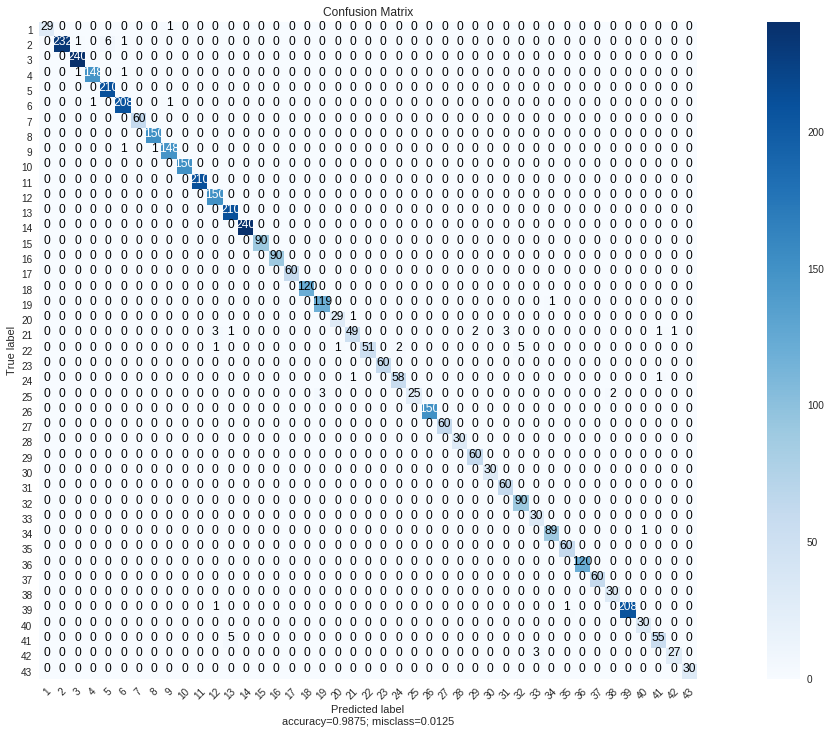

In [94]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = np.arange(1, 44),
                      title        = "Confusion Matrix")

In [95]:
precision = precision_score(y_valid_classes, y_pred, average='macro')
print(precision)

0.9840949238656782


In [96]:
recall = recall_score(y_valid_classes, y_pred, average='macro')
print(recall)

0.9794924326319675


# Testing

In [97]:
model2.evaluate(X_test, y_test)

12630/12630 [==============================] - 3s 265us/step


[0.09960372776773872, 0.9762470308505441]

In [0]:
new_images = ['https://anks4.github.io/Traffic-Sign-Classifier/images/img6.jpg',\
             'https://raw.githubusercontent.com/dhnkrn/Traffic-Sign-Classifier/master/images/german_3.jpg',\
             'https://www.autoeurope.com/default/assets/Image/germany-speed-limit-sign.png',\
             'https://www.autoeurope.com/default/assets/Image/german-stop-sign.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z103-20.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z103-10.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z133-10.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z205.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z274-100.png',
             'http://www.gettingaroundgermany.info/g_imgs/z274-60.png',\
             'http://www.gettingaroundgermany.info/g_imgs/z274-80.png']

In [0]:
!mkdir test_images

In [0]:
# !rm -r test_images

In [0]:
for image in new_images:
  wget.download(image, out='./test_images')

In [101]:
len(new_images)

11

In [0]:
new_test_images = np.array(list(map(lambda x: plt.imread(x), glob.glob('./test_images/*.png'))))
new_test_images = np.concatenate((new_test_images, np.array(list(map(lambda x: plt.imread(x), glob.glob('./test_images/*.jpg'))))))

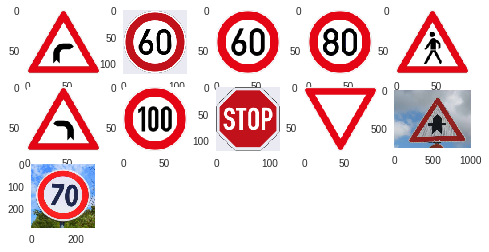

In [103]:
fig=plt.figure(figsize=(8, 4))
w=10
h=10
columns = 5
rows = 3
for i in range(1, new_test_images.shape[0] + 1):
  image = new_test_images[i-1]
  fig.add_subplot(rows, columns, i)
  plt.grid(False)
  plt.imshow(image)
plt.show()

In [0]:
target = np.array([[20], 
                   [3], 
                   [3],
                   [5],
                   [27],
                   [19],
                   [7], 
                   [14], 
                   [13],
                   [11],
                   [4]])

In [104]:
new_test_images_process = np.array(list(map(lambda x: rgb2gray(imresize(x, (32, 32))).reshape(32, 32, 1), new_test_images)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [117]:
model.evaluate(new_test_images_process, tf.keras.utils.to_categorical(target, 43))

11/11 [==============================] - 0s 891us/step


[1.6838085651397705, 0.7272727489471436]

In [0]:
predictions = model2.predict(new_test_images_process)

In [118]:
pred_classes = np.argmax(predictions, 1)
pred_classes

array([20,  3,  2,  1, 11, 19,  7, 14, 13, 11,  4])

In [0]:
top_5 = tf.nn.top_k(predictions, 5)

In [0]:
values = tf.keras.backend.eval(top_5[0])
indices = tf.keras.backend.eval(top_5[1])
table_data = np.array(list(map(lambda x: list(map(lambda y: signnames.iloc[y, 1], x)), indices)))
target_names = np.array(list(map(lambda x: signnames.iloc[x, 1], target.flatten()))).reshape((-1, 1))
table_df = np.concatenate((target_names, table_data), axis=1)
table_df = pd.DataFrame(table_df, columns=['Predicted', 'First', 'Second', 'Third', 'Fourth', 'Fifth'])

In [0]:
def highlight_right(data, color='green'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [157]:
table_df.style.bar(subset=['Predicted', 'First', 'Second', 'Third', 'Fourth', 'Fifth'], color='#d65f5f')
table_df

,Predicted,First,Second,Third,Fourth,Fifth
0,Dangerous curve to the right,Dangerous curve to the right,Slippery road,End of no passing,Children crossing,No passing
1,Speed limit (60km/h),Speed limit (60km/h),Speed limit (80km/h),Speed limit (50km/h),Speed limit (30km/h),End of speed limit (80km/h)
2,Speed limit (60km/h),Speed limit (50km/h),Speed limit (60km/h),Speed limit (80km/h),Speed limit (30km/h),Speed limit (100km/h)
3,Speed limit (80km/h),Speed limit (30km/h),Speed limit (20km/h),End of speed limit (80km/h),Speed limit (80km/h),Speed limit (50km/h)
4,Pedestrians,Right-of-way at the next intersection,Pedestrians,General caution,Road narrows on the right,Beware of ice/snow
5,Dangerous curve to the left,Dangerous curve to the left,Slippery road,Road narrows on the right,Double curve,Wild animals crossing
6,Speed limit (100km/h),Speed limit (100km/h),Speed limit (30km/h),Speed limit (120km/h),Speed limit (80km/h),Speed limit (50km/h)
7,Stop,Stop,Yield,Priority road,No vehicles,Keep right
8,Yield,Yield,Priority road,No vehicles,Ahead only,No passing
9,Right-of-way at the next intersection,Right-of-way at the next intersection,Beware of ice/snow,Pedestrians,Double curve,Road narrows on the right


In [194]:
head = """
<table>
    </tbody>

"""

for j in range(6):
  row = "<tr>"
  i = j*2
  while i < min(11, j*2 + 2):
    pred = table_df.iloc[i, 0]
    names = table_df.iloc[i, 1:]
    pos = pd.Series(values[i], index=names)
    pos.name=''
    if pred == names[0]:
      row += "<td><b>Predicted as: {}<b>{}</td>".format(pred, pos.to_frame().style.bar(
                                                         color=['#d65f5f', '#5fba7d'],
                                                         width=100).render()) #testn['width']
    else:
      row += "<td><b>Predicted as: {}<b>{}</td>".format(pred, pos.to_frame().style.bar(
                                                         color=['#5fba7d', '#d65f5f'],
                                                         width=100).render()) #testn['width']
    i+=1
  
  row += '</tr><br>'
  head += row

head+= """
</tbody>
</table>"""


HTML(head)

,
0,
Dangerous curve to the right,0.997045
Slippery road,0.00259909
End of no passing,0.000123676
Children crossing,0.000106267
No passing,7.86756e-05
,
1,
Speed limit (60km/h),0.9905
Speed limit (80km/h),0.00889208
